In [1]:
import os
import git
import sys

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(git_root)

import numpy as np
import random
from abm_vec.calibration import get_calibration_variables
from abm_vec.initialization import generate_random_entities
from abm_vec.essentials import wages_adj, compute_expected_supply_price
from abm_vec.firms import (
    check_loan_desire_and_choose_loans,
    get_non_zero_values_from_matrix,
    shuffle_firms,
)
from abm_vec.banks import asses_loan_requests_firms
from abm_vec.create_network_connections import create_network_connections
from abm_vec.clear_firm_default import clear_firm_default
from abm_vec.clear_interbank_market import clear_interbank_market

In [2]:
from scipy.stats import kstest

In [3]:
def get_le_ratio(x):
    seed_value = 0
    random.seed(seed_value)
    np.random.seed(seed_value)
    # get calibration variables for initialization and markov model
    calibration_variables = get_calibration_variables()
    calibration_variables['firm_mu1'] = x[0]
    calibration_variables['firm_mu2'] = x[1]
    calibration_variables['firm_sigma1'] = x[2]
    calibration_variables['firm_sigma2'] = x[3]
    calibration_variables['firm_xi1'] = x[4]
    calibration_variables['firm_xi2'] = x[5]
    calibration_variables['firm_rho'] = x[6]
    
    (
    bank_equity,
    bank_deposits,
    bank_loans,
    bank_t1_cap,
    firm_equity,
    firm_prod,
    firm_ex_supply,
    firm_wage,
    firm_pd,
    firm_supply,
    firm_profit,
    firm_price,
    firm_max_leverage) = generate_random_entities(calibration_variables)

    num_firms = len(firm_price)
    num_banks = len(bank_loans)

    t = 0

    (
        firm_equity,
        firm_prod,
        firm_ex_supply,
        firm_wage,
        firm_pd,
        firm_supply,
        firm_profit,
        firm_price,
        firm_max_leverage,
    ) = shuffle_firms(
        num_firms,
        firm_equity,
        firm_prod,
        firm_ex_supply,
        firm_wage,
        firm_pd,
        firm_supply,
        firm_profit,
        firm_price,
        firm_max_leverage,
    )

    # for each firm compute expected supply and see who wants loans
    firm_wage = wages_adj(firm_wage, calibration_variables["min_wage"])
    firm_price, firm_supply, firm_total_wage = compute_expected_supply_price(
        firm_ex_supply,
        firm_supply,
        firm_price,
        calibration_variables["market_price"],
        firm_wage,
        firm_prod,
        calibration_variables["firm_init_excess_supply_prob"],
        firm_profit,
        firm_max_leverage,
        firm_equity,
    )

    firm_credit_demand = np.maximum(0, firm_total_wage - firm_equity)
    firm_financial_fragility = firm_credit_demand / firm_equity
    loan_indicator = check_loan_desire_and_choose_loans(
        firm_credit_demand, num_firms, num_banks, calibration_variables["max_bank_loan"]
    )

    # let bank give interest rates
    bank_current_deposit = bank_deposits.copy()
    bank_max_credit = bank_deposits / calibration_variables["capital_req"]
    firm_interest = asses_loan_requests_firms(
        loan_indicator,
        firm_credit_demand,
        bank_max_credit,
        firm_pd,
        firm_financial_fragility,
        calibration_variables["policy_rate"],
        calibration_variables["h_theta"],
    )

    # get loans by firm
    loans_by_firm = get_non_zero_values_from_matrix(firm_interest)

    # compute network connections
    #notice that we do not have any interbank loans. Probably because there are too many deposits in relation to loan demand
    (loan_firms_interest,
     loan_firms_amount,
     loan_banks_interest,
     loan_banks_amount,
     cds_amount,
     cds_spread,
     cds_spread_amount,
     bank_current_deposit,
     firm_equity,
     cds_dict,
     bank_loan_asset
     ) = create_network_connections(loans_by_firm,
                                    calibration_variables,
                                    num_firms,
                                    num_banks,
                                    firm_credit_demand,
                                    bank_max_credit,
                                    bank_deposits,
                                    bank_current_deposit,
                                    firm_equity,
                                    firm_pd,
                                    bank_equity)

    empirical_le_ratio = bank_loans / bank_equity
    simulated_le_ratio = bank_loan_asset / bank_equity
    return kstest(empirical_le_ratio, simulated_le_ratio, alternative='two-sided').pvalue #, empirical_le_ratio, simulated_le_ratio

In [4]:
def fun_min(x):
    return -get_le_ratio(x)

In [5]:
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

In [10]:
bounds = [(10 ** 4, 10**6), (10 ** 5, 10**7), (0, 100), (0, 100), (-5, 5), (-5, 5), (0, 1)]
initial_guess = [10 ** 5, 10 ** 6, 50, 50, 0.2, 0.2, 0.3]

In [11]:
result = minimize(fun_min, initial_guess, method='Nelder-Mead', bounds=bounds)

In [12]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -0.2424351142427097
             x: [ 1.050e+05  1.000e+06  5.000e+01  5.000e+01  2.000e-01
                  2.000e-01  3.000e-01]
           nit: 41
          nfev: 281
 final_simplex: (array([[ 1.050e+05,  1.000e+06, ...,  2.000e-01,
                         3.000e-01],
                       [ 1.050e+05,  1.000e+06, ...,  2.000e-01,
                         3.000e-01],
                       ...,
                       [ 1.050e+05,  1.000e+06, ...,  2.000e-01,
                         3.000e-01],
                       [ 1.050e+05,  1.000e+06, ...,  2.000e-01,
                         3.000e-01]]), array([-2.424e-01, -2.424e-01, -2.424e-01, -2.424e-01,
                       -2.424e-01, -2.424e-01, -2.424e-01, -2.424e-01]))

# q-q plot

In [13]:
import matplotlib.pyplot as plt
from scipy import stats
import openturns as ot

In [16]:
[mu1, mu2, sigma1, sigma2, xi1, xi2, rho] = [ 1.050e+05,  1.000e+06,  5.000e+01,  5.000e+01,  2.000e-01, 2.000e-01,  3.000e-01]
x1 = ot.GeneralizedPareto(sigma1, xi1)
x2 = ot.GeneralizedPareto(sigma2, xi2)
R = ot.CorrelationMatrix(2)
R[0, 1] = rho
R[1, 0] = rho
copula = ot.NormalCopula(R)
dist = ot.ComposedDistribution([x1, x2], copula)
sample = dist.getSample(10000)

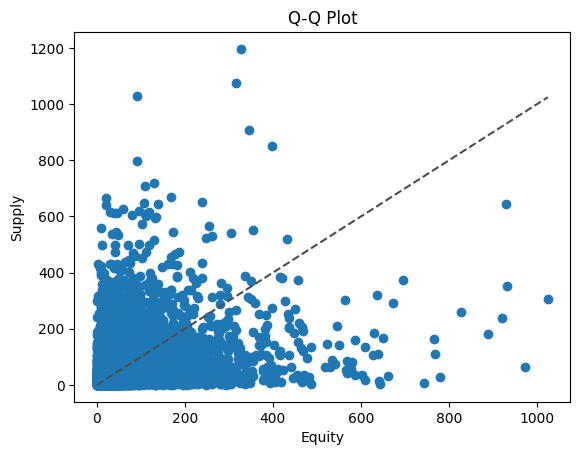

In [21]:
quantiles1 = np.array(sample[:, 0]).T[0]
quantiles2 = np.array(sample[:, 1]).T[0]
plt.scatter(quantiles1, quantiles2)
plt.xlabel('Equity')
plt.ylabel('Supply')
plt.title('Q-Q Plot')
plt.plot([quantiles1.min(), quantiles1.max()], [quantiles1.min(), quantiles1.max()], ls="--", c=".3")
plt.show()

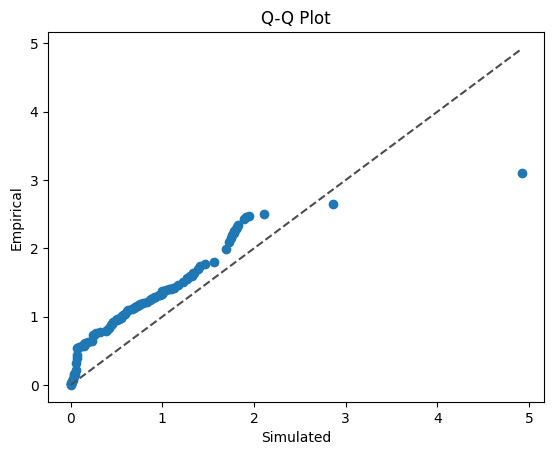

In [52]:

#a, empirical_le_ratio, simulated_le_ratio = get_le_ratio(x)

# Compute quantiles
quantiles1 = np.percentile(simulated_le_ratio, np.linspace(0, 100, 100))
quantiles2 = np.percentile(empirical_le_ratio, np.linspace(0, 100, 100))

plt.scatter(quantiles1, quantiles2)
plt.xlabel('Simulated')
plt.ylabel('Empirical')
plt.title('Q-Q Plot')
plt.plot([quantiles1.min(), quantiles1.max()], [quantiles1.min(), quantiles1.max()], ls="--", c=".3")
plt.show()

In [7]:
def fun_min(x):
    return -get_le_ratio(x)

In [8]:
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

In [9]:
bounds = [(10 ** 5, 10**10), (10 ** 5, 10**20), (0, 5), (0, 5), (-5, 2), (-5, 2), (0, 1)]

In [10]:
initial_guess = [10 ** 6, 10 ** 6,0.1, 0.1, 0.2, 0.2, 0.5]

In [11]:
result = minimize(fun_min, initial_guess, method='Powell', bounds=bounds)

In [12]:
result

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -2.7638617227251404e-43
       x: [ 1.000e+10  1.000e+20  5.000e+00  5.000e+00  2.000e+00
            2.000e+00  9.999e-01]
     nit: 1
   direc: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
           ...
           [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
    nfev: 193

In [4]:
(1+ 0.025) * 80000/624


131.4102564102564